In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap


In [73]:
class SurvivalPredictorSVM:
    def __init__(self, filepath):
        self.survivalset = pd.read_csv(filepath)
        self.preprocess()
        self.apply_pca()
        self.m = self.X.shape[0]
        self.n = self.X.shape[1]
        self.w = np.zeros(self.n)
        self.b = 0
        self.cost_history = []
        self.split_index = int(0.85 * self.m)
        self.split_data()
        

    def preprocess(self):
        self.survivalset = self.survivalset.dropna(subset=['Age'])
        self.correlationdata = self.survivalset.drop(columns=['Cabin'])
        self.correlationdata = pd.get_dummies(self.correlationdata, columns=['Sex','Embarked'])
        self.correlationdata = self.correlationdata.replace({True: 1, False: 0})
        self.correlationdata = self.correlationdata.drop(columns=['PassengerId', 'Name', 'Ticket'])
        self.survivalset = pd.get_dummies(self.survivalset, columns=['Sex','Cabin','Embarked'])
        self.survivalset = self.survivalset.replace({True: 1, False: 0})
        self.correlation_matrix = self.correlationdata.corr()
        self.X = self.survivalset[list(self.survivalset.columns.difference(['PassengerId', 'Survived', 'Name', 'Ticket']))].values
        self.Y = self.survivalset['Survived'].replace({0: -1, 1: 1}).values
        self.X = (self.X - self.X.mean(axis=0)) / self.X.std(axis=0)

    def apply_pca(self):
        covariance_matrix = np.cov(self.X, rowvar=False)
        self.eigenvalues, self.eigenvectors = np.linalg.eig(covariance_matrix)
        sorted_indices = np.argsort(self.eigenvalues)[::-1]
        self.eigenvalues = self.eigenvalues[sorted_indices]
        self.eigenvectors = self.eigenvectors[:, sorted_indices]
        total_variance = np.sum(self.eigenvalues)
        variance_ratio = self.eigenvalues / total_variance
        cumulative_variance = np.cumsum(variance_ratio)
        self.n_components = np.argmax(cumulative_variance >= 0.99) + 1
        print(self.n_components)
        self.eigenvectors = self.eigenvectors[:, :self.n_components]
        self.X = np.dot(self.X, self.eigenvectors)

        plt.figure(figsize=(10, 6))
        plt.bar(range(1, len(self.eigenvalues) + 1), self.eigenvalues, color='skyblue')
        plt.xlabel('Principal Component')
        plt.ylabel('Eigenvalue (Variance Explained)')
        plt.title('Eigenvalues vs Principal Components')
        plt.show()


    

    

    def split_data(self):
        self.X_train, self.X_test = self.X[:self.split_index], self.X[self.split_index:]
        self.Y_train, self.Y_test = self.Y[:self.split_index], self.Y[self.split_index:]

    def compute_cost(self):
        hinge_loss = 0
        for i in range(self.split_index):
            hinge_loss += max(0, 1 - self.Y_train[i] * (np.dot(self.X_train[i], self.w) + self.b))
        regularization = (1 / 2) * np.dot(self.w, self.w)
        return hinge_loss / self.split_index + regularization

    def gradient_descent(self, alpha, iterations):
        for _ in range(iterations):
            dw = np.zeros(self.n)
            db = 0
            for i in range(self.split_index):
                condition = self.Y_train[i] * (np.dot(self.X_train[i], self.w) + self.b)
                if condition < 1:
                    dw += np.real(-self.Y_train[i] * self.X_train[i])
                    db += -self.Y_train[i]
                dw += self.w  
            self.w -= alpha * dw / self.split_index
            self.b -= alpha * db / self.split_index
            cost = self.compute_cost()
            self.cost_history.append(cost)

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b).astype(int)

    def f1_score(self, predictions):
        TP, FP, FN = 0, 0, 0
        for i in range(self.m - self.split_index):
            if predictions[i] == 1 and self.Y_test[i] == 1:
                TP += 1
            elif predictions[i] == 1 and self.Y_test[i] == 0:
                FP += 1
            elif predictions[i] == -1 and self.Y_test[i] == 1:
                FN += 1
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        return f1

    def train(self):
        self.gradient_descent(0.01, 500)

    def display_correlation_matrix(self):
        plt.figure(figsize=(12, 8))
        sns.heatmap(self.correlation_matrix, annot=True, cmap='Blues', fmt='.2f')
        plt.title("Correlation Matrix Heatmap")
        plt.show()

    def confusion_matrix(self):
        predictions = self.predict(self.X_test)
        cm = confusion_matrix(self.Y_test, predictions)
        return cm

    def plot_confusion_matrix(self):
        cm = self.confusion_matrix()
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted Negative", "Predicted Positive"], yticklabels=["Actual Negative", "Actual Positive"])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

    def plot_svm_decision_boundary(self):
        X_2d = self.X[:, :2]  
        self.split_index_2d = int(0.85 * X_2d.shape[0])
        X_train_2d, X_test_2d = X_2d[:self.split_index_2d], X_2d[self.split_index_2d:]
        Y_train_2d, Y_test_2d = self.Y[:self.split_index_2d], self.Y[self.split_index_2d:]
        self.gradient_descent(0.01, 500)
        x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
        y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
        Z = np.dot(np.c_[xx.ravel(), yy.ravel()], self.w[:2]) + self.b
        Z = Z.reshape(xx.shape)
        plt.figure(figsize=(10, 6))
        plt.contourf(xx, yy, Z, levels=[-1, 0, 1], cmap="coolwarm", alpha=0.3)
        plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=Y_test_2d, cmap="coolwarm", marker='x', s=100)

        plt.title("SVM Decision Boundary with First Two Principal Components")
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.show()

    


C:\Users\pkmna\AppData\Local\Temp\ipykernel_30328\2631048580.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.correlationdata = self.correlationdata.replace({True: 1, False: 0})
C:\Users\pkmna\AppData\Local\Temp\ipykernel_30328\2631048580.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.survivalset = self.survivalset.replace({True: 1, False: 0})


138


C:\Users\pkmna\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\pkmna\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\transforms.py:767: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


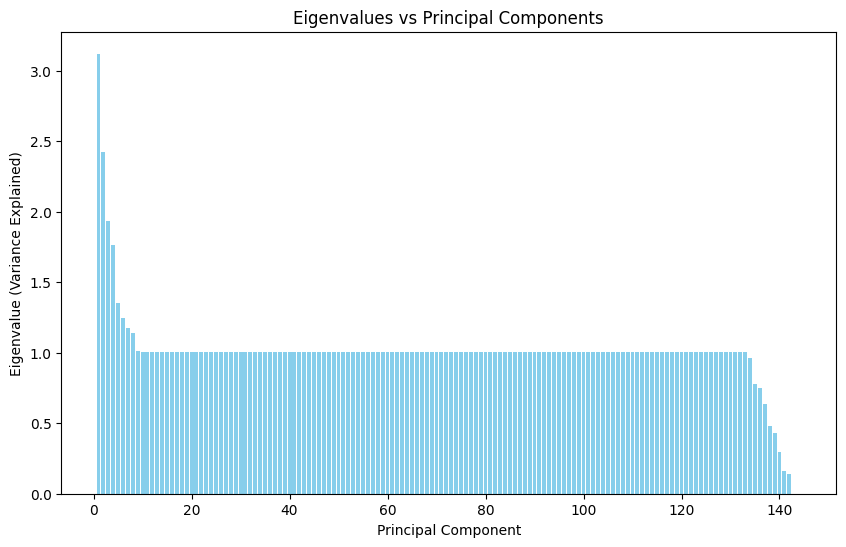

C:\Users\pkmna\AppData\Local\Temp\ipykernel_30328\2631048580.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.sign(np.dot(X, self.w) + self.b).astype(int)
C:\Users\pkmna\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


F1 score: 0.84


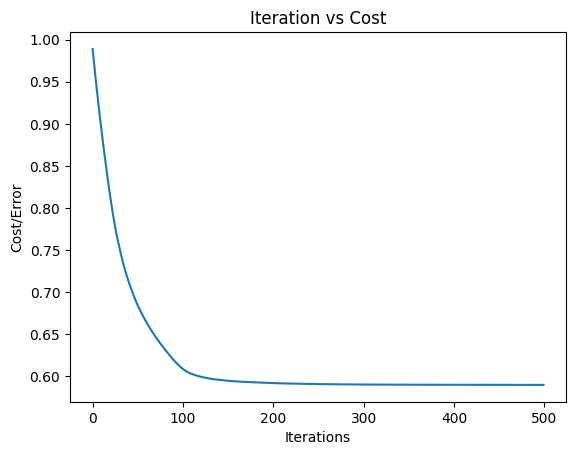

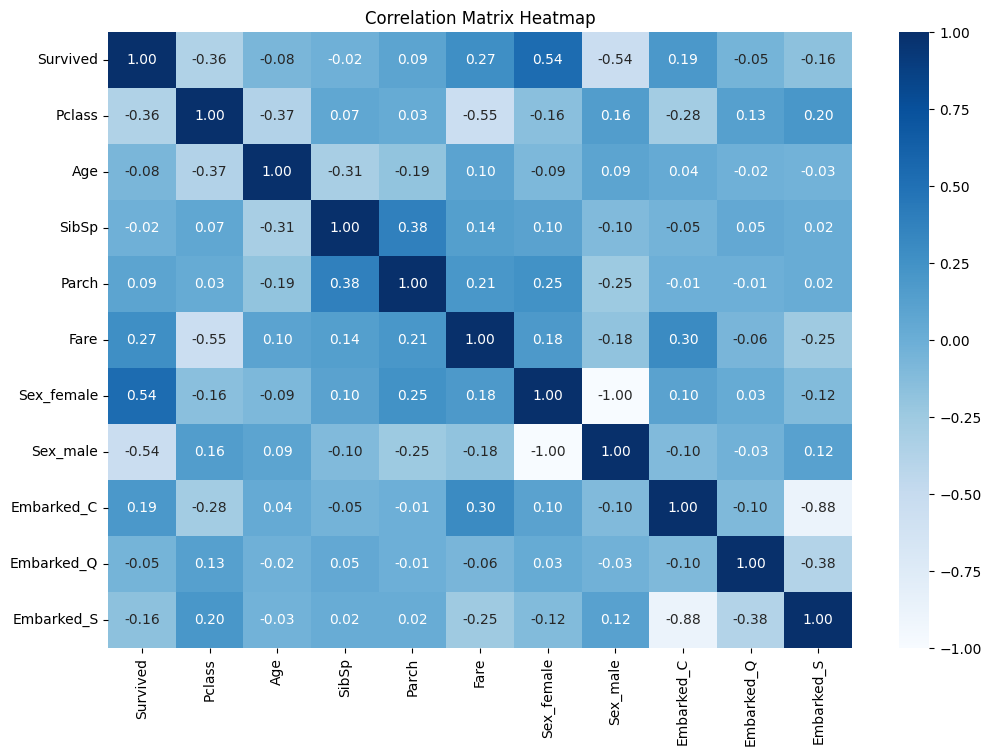

C:\Users\pkmna\AppData\Local\Temp\ipykernel_30328\2631048580.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.sign(np.dot(X, self.w) + self.b).astype(int)


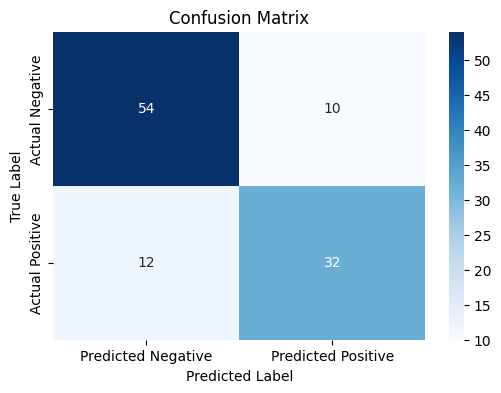

In [ ]:
if __name__ == "__main__":
    predictor = SurvivalPredictorSVM(r"C:\Users\pkmna\Downloads\titanic.csv")
    predictor.train()
    f1score = predictor.f1_score(predictor.predict(predictor.X_test))
    print("F1 score: %.2f" % f1score)
    plt.plot(predictor.cost_history)
    plt.title("Iteration vs Cost")
    plt.xlabel("Iterations")
    plt.ylabel("Cost/Error")
    plt.show()
    predictor.display_correlation_matrix()
    predictor.plot_confusion_matrix()
    predictor.plot_svm_decision_boundary()
    
    
